# Mapping with `splot` and `PySAL`

### Imports

In [1]:
import libpysal as lp
from libpysal import examples
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

% matplotlib inline

### Data Preparation

Load example data into a `geopandas.GeoDataFrame` and inspect column names. In this example we will use the `columbus.shp` file containing neighborhood crime data of 1980.

In [2]:
link_to_data = examples.get_path('columbus.shp')
gdf = gpd.read_file(link_to_data)
gdf.columns

Index(['AREA', 'PERIMETER', 'COLUMBUS_', 'COLUMBUS_I', 'POLYID', 'NEIG',
       'HOVAL', 'INC', 'CRIME', 'OPEN', 'PLUMB', 'DISCBD', 'X', 'Y', 'NSA',
       'NSB', 'EW', 'CP', 'THOUS', 'NEIGNO', 'geometry'],
      dtype='object')

We extract two arrays `x` (housing value (in $1,000)) and `y` (residential burglaries and vehicle thefts per 1000 households).

In [3]:
x = gdf['HOVAL'].values
y = gdf['CRIME'].values

# Create Value-by-Alpha Choropleths using the `splot.mapping` functionality

### What is a Value by Alpha choropleth?

In a nutshell, a Value-by-Alpha Choropleth is a bivariate choropleth that uses the values of the second input variable `y` as a transparency mask, determining how much of the choropleth displaying the values of a first variable `x` is shown. In comparison to a cartogram, Value-By-Alpha choropleths will not distort shapes and sizes but modify the alpha channel (transparency) of polygons according to the second input variable `y`.

Let's look at a couple of examples generated with `splot`.

In [4]:
from splot.mapping import vba_choropleth

We can create a value by alpha map using `splot`'s `vba_choropleth` functionality.

We will plot a Value-by-Alpha Choropleth with `x` defining the rgb values and `y` defining the alpha value. For comparison we plot a choropleth of `x` with `gdf.plot()`:

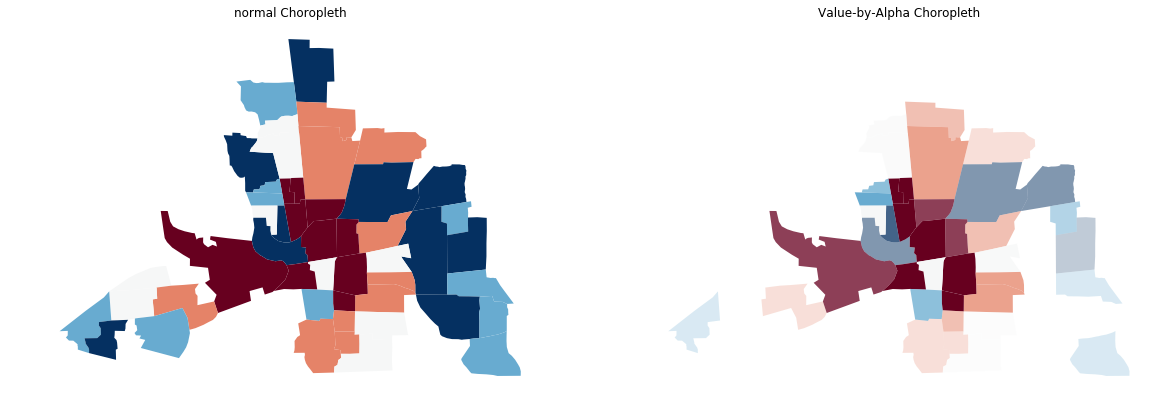

In [5]:
# Create new figure
fig, axs = plt.subplots(1,2, figsize=(20,10))

# use gdf.plot() to create regular choropleth
gdf.plot(column='HOVAL', scheme='quantiles', cmap='RdBu', ax=axs[0])

# use vba_choropleth to create Value-by-Alpha Choropleth
vba_choropleth(x, y, gdf, rgb_mapclassify=dict(classifier='quantiles'),
               alpha_mapclassify=dict(classifier='quantiles'),
               cmap='RdBu', ax=axs[1])

# set figure style
axs[0].set_title('normal Choropleth')
axs[0].set_axis_off()
axs[1].set_title('Value-by-Alpha Choropleth')

# plot
plt.show()

You can see the original choropleth is fading into transparency wherever there is a high `y` value.

You can use the option to bin or classify your `x` and `y` values. `splot` uses mapclassify to bin your data and displays the new color and alpha ranges:

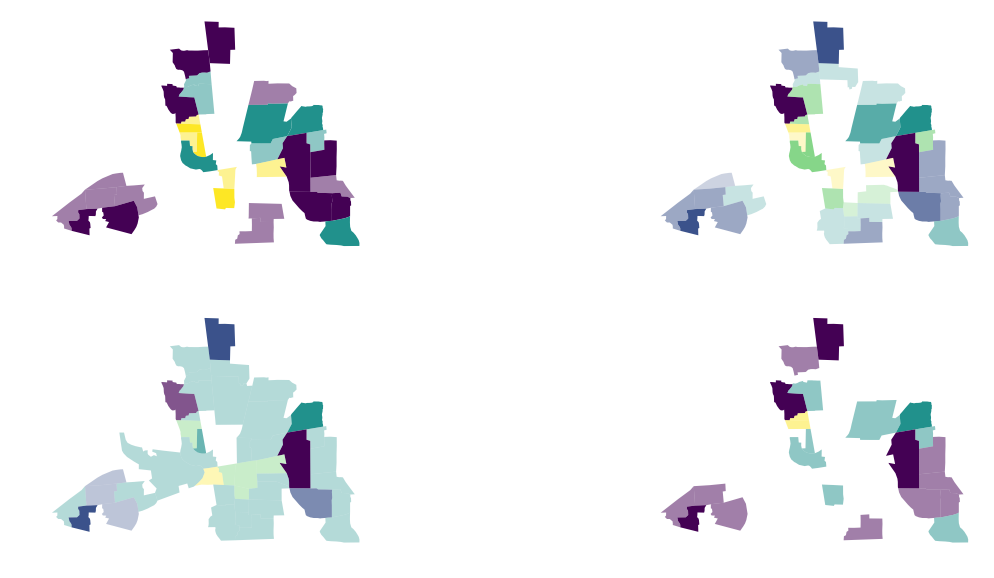

In [6]:
# Create new figure
fig, axs = plt.subplots(2,2, figsize=(20,10))

# classifier quantiles
vba_choropleth(y, x, gdf, cmap='viridis', ax = axs[0,0],
               rgb_mapclassify=dict(classifier='quantiles', k=3), 
               alpha_mapclassify=dict(classifier='quantiles', k=3))

# classifier natural_breaks
vba_choropleth(y, x, gdf, cmap='viridis', ax = axs[0,1],
               rgb_mapclassify=dict(classifier='natural_breaks'), 
               alpha_mapclassify=dict(classifier='natural_breaks'))

# classifier std_mean
vba_choropleth(y, x, gdf, cmap='viridis', ax = axs[1,0],
               rgb_mapclassify=dict(classifier='std_mean'), 
               alpha_mapclassify=dict(classifier='std_mean'))

# classifier fisher_jenks
vba_choropleth(y, x, gdf, cmap='viridis', ax = axs[1,1],
               rgb_mapclassify=dict(classifier='fisher_jenks', k=3), 
               alpha_mapclassify=dict(classifier='fisher_jenks', k=3))

plt.show()

Instead of using a colormap you can also pass a list of colors:

In [7]:
color_list = ['#a1dab4','#41b6c4','#225ea8']

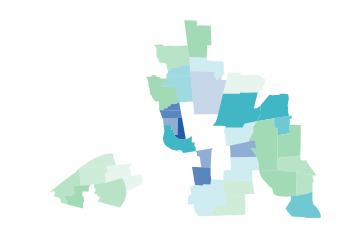

In [8]:
vba_choropleth(y, x, gdf, cmap=color_list,
               rgb_mapclassify=dict(classifier='quantiles', k=3), 
               alpha_mapclassify=dict(classifier='quantiles'))
plt.show()

Sometimes it is important in geospatial analysis to actually see the high values and let the small values fade out. With the `revert_alpha = True` argument, you can revert the transparency of the `y` values.

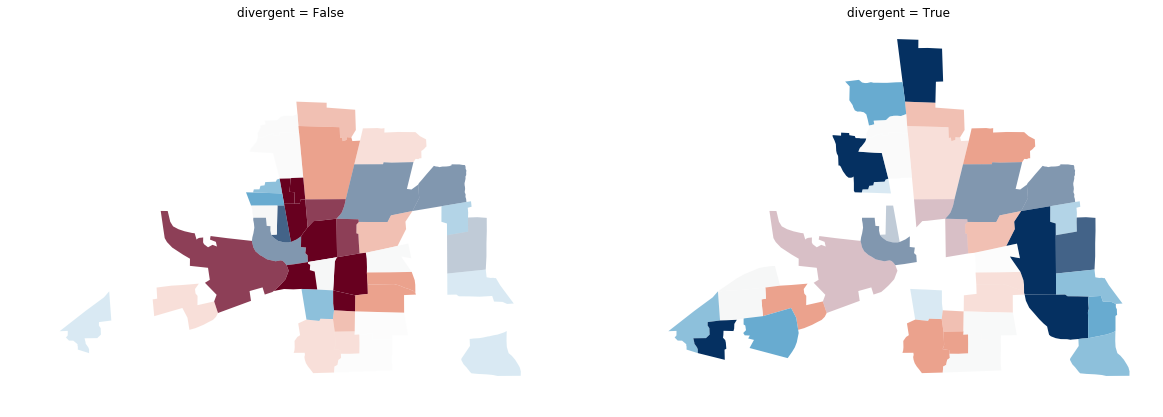

In [9]:
# Create new figure
fig, axs = plt.subplots(1,2, figsize=(20,10))

# create a vba_choropleth
vba_choropleth(x, y, gdf, rgb_mapclassify=dict(classifier='quantiles'),
               alpha_mapclassify=dict(classifier='quantiles'),
               cmap='RdBu', ax=axs[0],
               revert_alpha=False)

# set revert_alpha argument to True
vba_choropleth(x, y, gdf, rgb_mapclassify=dict(classifier='quantiles'),
               alpha_mapclassify=dict(classifier='quantiles'),
               cmap='RdBu', ax=axs[1],
               revert_alpha = True)

# set figure style
axs[0].set_title('divergent = False')
axs[1].set_title('divergent = True')

# plot
plt.show()

You can use the `divergent` argument to display divergent alpha values. This means values at the extremes of your data range will be displayed with an alpha value of 1. Values towards the middle of your data range will be mapped more and more invisible towards an alpha value of 0.

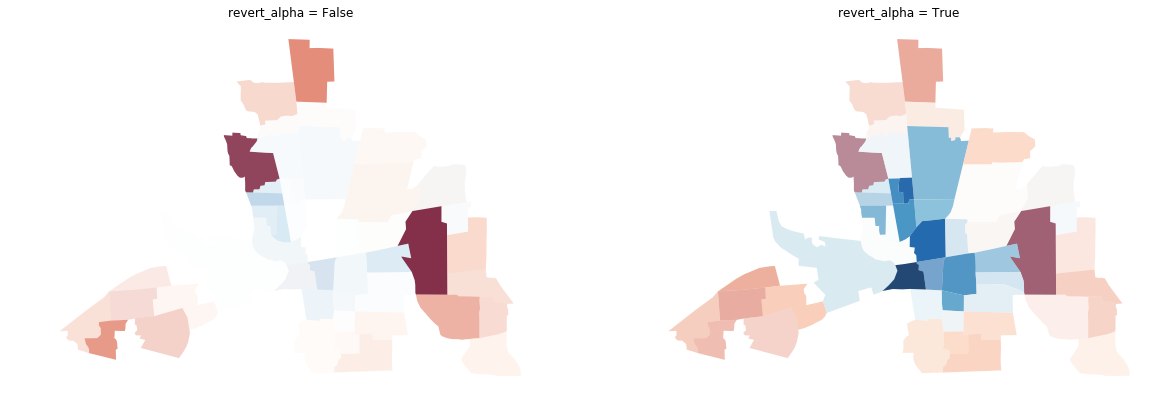

In [10]:
# create new figure
fig, axs = plt.subplots(1,2, figsize=(20,10))

# create a vba_choropleth
vba_choropleth(y, x, gdf, cmap='RdBu',
               divergent=False, ax=axs[0])

# set divergent to True
vba_choropleth(y, x, gdf, cmap='RdBu',
               divergent=True, ax=axs[1])

# set figure style
axs[0].set_title('revert_alpha = False')
axs[0].set_axis_off()
axs[1].set_title('revert_alpha = True')

# plot
plt.show()

# Create your own cmap for plotting

Sometimes you need to display divergent values with a natural midpoint not overlapping with he median of your data. For example if you measure the temperature over a country ranging from -2 to 10 degrees Celsius. Or if you need to assess wether a certain threshold is reached.

For cases like this `splot` provides a utility function to shift your colormap.

In [11]:
from splot._viz_utils import shift_colormap

In [12]:
# shift the midpoint to the 80st percentile of your datarange
mid08 = shift_colormap('RdBu', midpoint=0.8)

# shift the midpoint to the 20st percentile of your datarange
mid02 = shift_colormap('RdBu', midpoint=0.2)

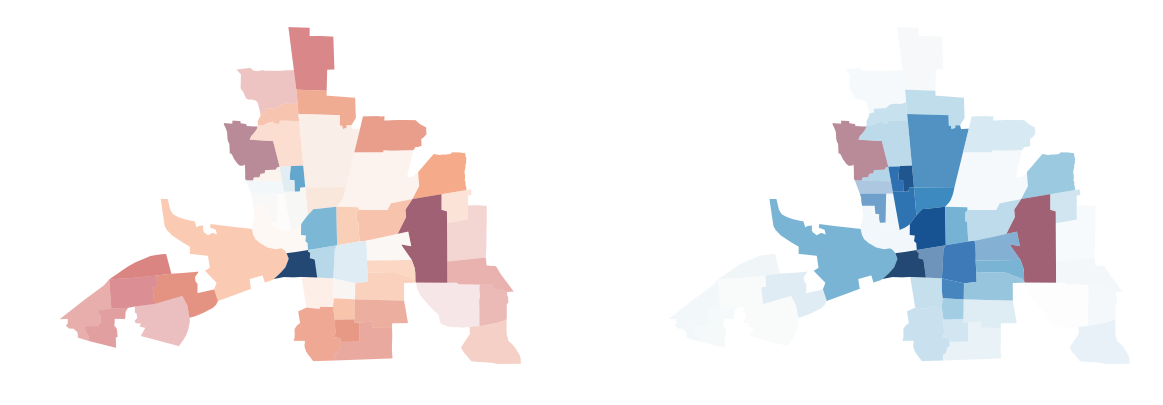

In [26]:
# create new figure
fig, axs = plt.subplots(1,2, figsize=(20,10))

# vba_choropleth with cmap mid08
vba_choropleth(y, x, gdf, cmap=mid08, ax=axs[0], divergent=True)

# vba_choropleth with cmap mid02
vba_choropleth(y, x, gdf, cmap=mid02, ax=axs[1], divergent=True)

# plot
plt.show()

# Add a legend

If your values are classified, you have the option to add a legend to your map.

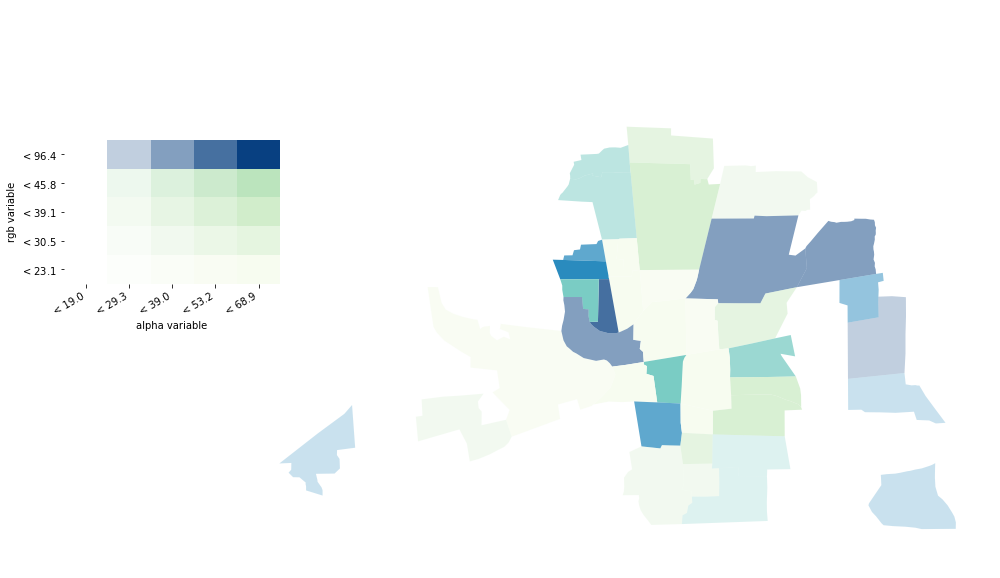

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
vba_choropleth(x, y, gdf,
               alpha_mapclassify=dict(classifier='quantiles', k=5),
               rgb_mapclassify=dict(classifier='quantiles', k=5),
               legend=True, ax=ax)
plt.show()